# Predict My Sleep : Quick start

## Credit :
Notebook that help me : 
- Lev Perla's notebook [here](https://www.kaggle.com/code/ray328/eda-and-random-submission)

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/kaggle-pog-series-s01e04/sample_submission.csv
/kaggle/input/kaggle-pog-series-s01e04/train_detailed.csv
/kaggle/input/kaggle-pog-series-s01e04/raw_health_export.xml
/kaggle/input/kaggle-pog-series-s01e04/train.csv
/kaggle/input/kaggle-pog-series-s01e04/test.csv


# Import and loading data

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from pathlib import Path

In [3]:
DATA_DIR = Path("/kaggle/input/kaggle-pog-series-s01e04/")
train_df = pd.read_csv(DATA_DIR / "train.csv")
submission = pd.read_csv(DATA_DIR / "sample_submission.csv")

## Data Shape 
**Train data have 2354 samples (days)** 

In [4]:
train_df.shape

(2354, 2)

### Converte string to Datetime

Before
```
train_df.dtypes

>>>date            object
>>>sleep_hours    float64
>>>dtype: object
```

**Train date start 19/FEB/2015 and finish 31/DEC/2021**

In [5]:
train_df["date"] = pd.to_datetime(train_df["date"])
train_df = train_df.set_index("date")

full_ind = pd.date_range(train_df.index.min(), train_df.index.max()) # some day are missing
train_df = train_df.reindex(full_ind, fill_value=np.nan)

train_df

,sleep_hours
2015-02-19,6.400000
2015-02-20,7.583333
2015-02-21,6.350000
2015-02-22,6.500000
2015-02-23,8.916667
...,...
2021-12-27,NaN
2021-12-28,NaN
2021-12-29,6.175000
2021-12-30,5.158333


In [6]:
train_df.shape

(2508, 1)

### Date For submission

**submission date start the 01/JAN/2022 and finish the 16/MARCH/2023**

**Test data have 419 sample (days)**

In [7]:
# Date For submission
submission.take((0, -1))

,date,sleep_hours
0,2022-01-01,1
418,2023-03-16,1


## EDA 

<AxesSubplot:>

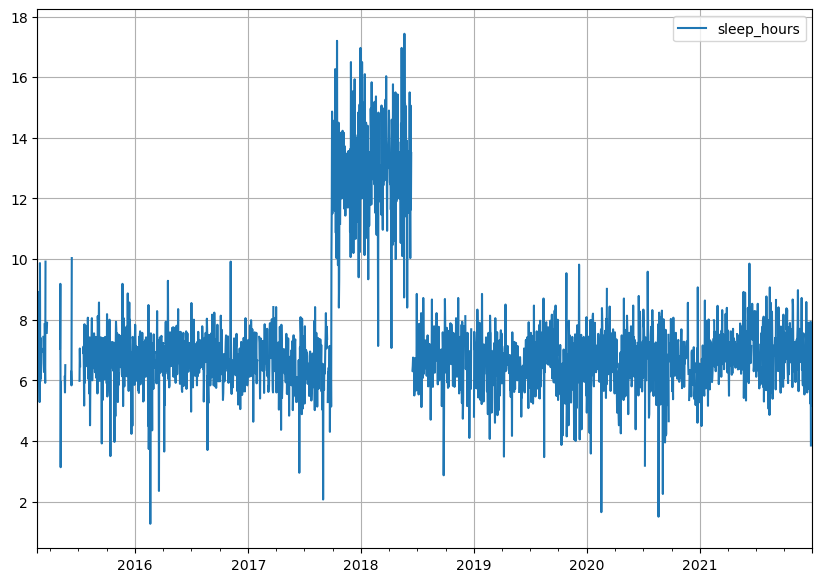

In [8]:
# global plot
train_df.plot(figsize=(10, 7), grid=True)

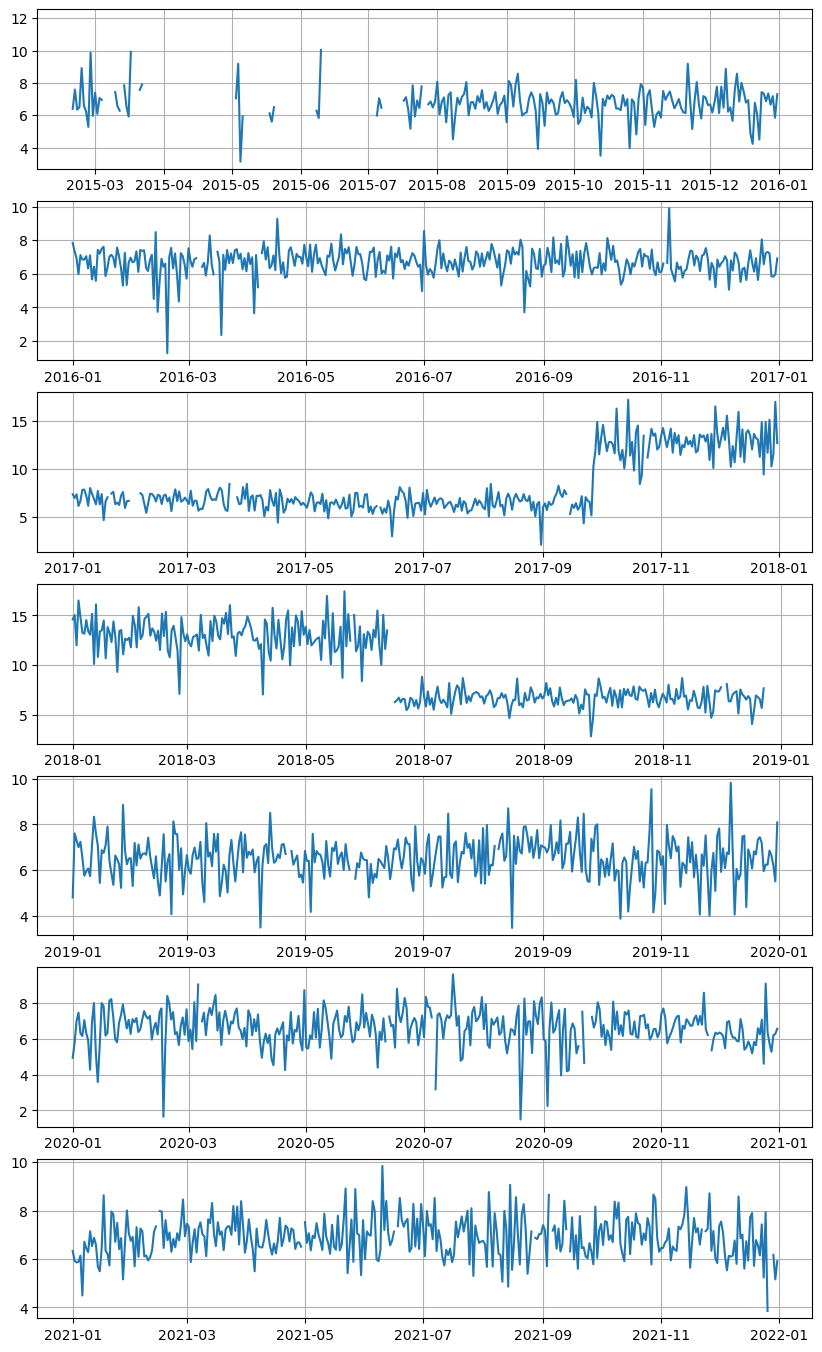

In [9]:
years_list = train_df.index.year.unique()
N_YEAR = len(years_list)

fig, axs = plt.subplots(N_YEAR, figsize=(10,17))

for i, year in enumerate(years_list) :
    df = train_df.loc[str(year)]
    axs[i].plot(df.index, df["sleep_hours"])
    axs[i].grid(True)

### Check `NaN` values

154 day missing

In [10]:
int(np.sum(train_df.isna(), axis=0))

154

## Missing data group by year :

In [11]:
train_df.isna().groupby(train_df.index.year).sum()

,sleep_hours
2015,102
2016,5
2017,12
2018,13
2019,5
2020,8
2021,9


## Histogram sleep hours

array([[<AxesSubplot:title={'center':'sleep_hours'}>]], dtype=object)

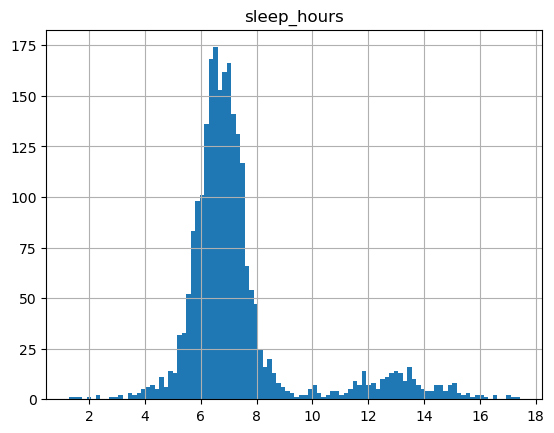

In [12]:
train_df.dropna().hist(bins=100)

## Summarry 

- Train data = 2354 days
- Test Data = 419 days (start when train days end)
- Missing data = 154 days (mostly 2015)
- There are outliers in end of 2017 and start of 2018 

# Preprocess

## Process outiers

In [13]:
outliers_dates = ('2017-09-26', '2018-06-13')
outliers_mask = ((train_df.index >= outliers_dates[0]) & (train_df.index <= outliers_dates[1]))

In [14]:
mean_regilar = train_df.loc[~outliers_mask]["sleep_hours"].mean()
std_regilar = train_df.loc[~outliers_mask]["sleep_hours"].std()
mean_outliers = train_df.loc[outliers_mask]["sleep_hours"].mean()
std_outliers = train_df.loc[outliers_mask]["sleep_hours"].std()

ratio_mean = mean_outliers / mean_regilar
ratio_std = std_outliers / std_regilar

print(f'Regular mean sleep hours is {mean_regilar:.2f} and std is {std_regilar:.2f}')
print(f'Outliers mean sleep hours is {mean_outliers:.2f} and std is {std_outliers:.2f}', end="\n\n")
print(f"""The ratio between outlier and regular mean is {ratio_mean:.2f} 
and the ratio between outlier and regularstd is {ratio_std:.2f}""")

Regular mean sleep hours is 6.67 and std is 0.93
Outliers mean sleep hours is 12.91 and std is 1.76

The ratio between outlier and regular mean is 1.93 
and the ratio between outlier and regularstd is 1.91


<AxesSubplot:>

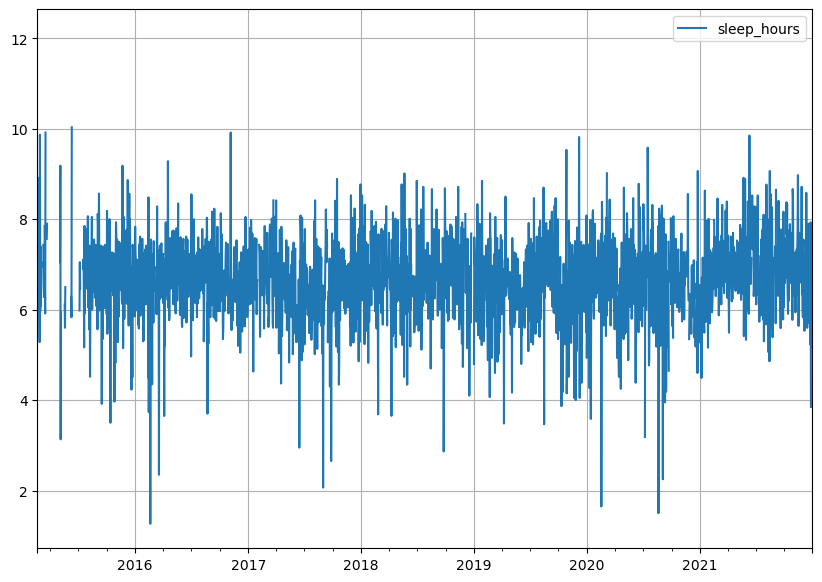

In [15]:
process_train_df = train_df.copy()

process_train_df.loc[outliers_mask, 'sleep_hours'] = process_train_df.loc[outliers_mask, 'sleep_hours'] / ratio_mean
process_train_df.plot(figsize=(10, 7), grid=True)

array([[<AxesSubplot:title={'center':'sleep_hours'}>]], dtype=object)

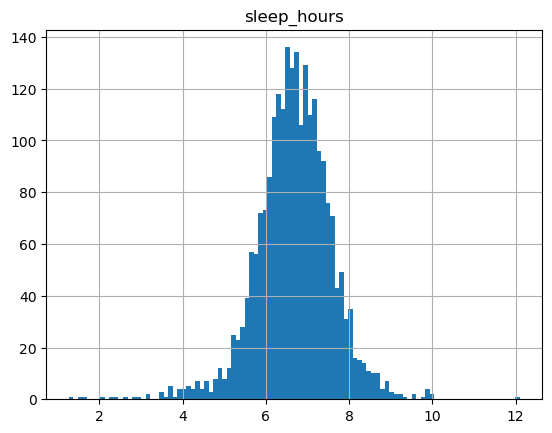

In [16]:
process_train_df.dropna().hist(bins=100)

## Remove 2015 data (to much NaN values)

In [17]:
process_train_df = process_train_df.loc[process_train_df.index >= "2016"]

<AxesSubplot:>

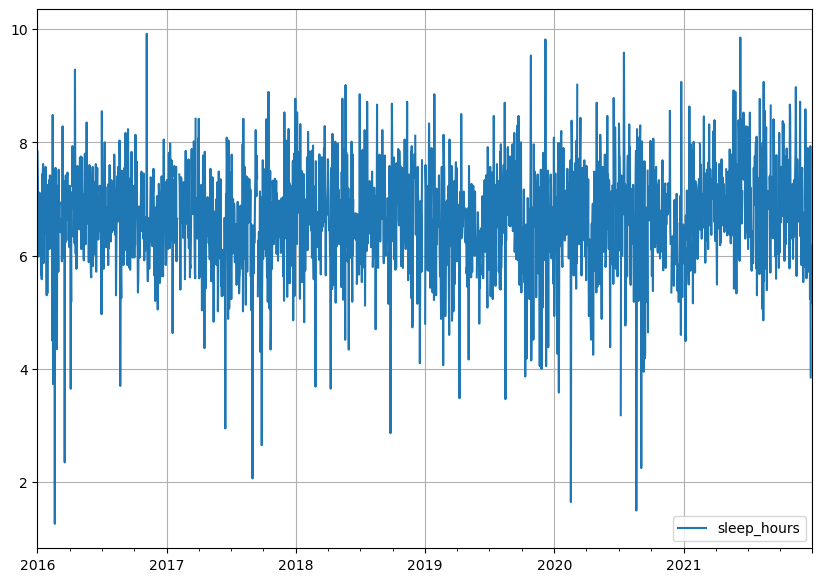

In [18]:
process_train_df.plot(figsize=(10, 7), grid=True)

# Modeling

In [19]:
# Constant
SHAPE = submission.shape

## usefull function

In [20]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred, **kw):
    return np.sqrt(mean_squared_error(y_true, y_pred, **kw))

## Median modeling for baseline

In [21]:
process_train_df.shape

(2192, 1)

In [22]:
submission["sleep_hours"] = np.full(SHAPE[0],process_train_df.median())

In [23]:
rmse(process_train_df["sleep_hours"].dropna(), np.full(process_train_df.dropna().shape[0],process_train_df.median()))

0.9070305745691397

lol that quiet good

In [24]:
submission.to_csv('submission.csv', index=False)

## ML

In [25]:
# todo 